In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [48]:
import os
PathToRepo = os.path.normpath(os.getcwd() + os.sep + os.pardir)
Df = pd.read_csv('Faellesdata_cleaned.csv')

In [49]:
x_train, x_test, y_train, y_test = train_test_split(Df.drop('IsMigratorInt', axis=1), Df['IsMigratorInt'], test_size=0.2, random_state=42)

In [50]:
import statsmodels.api as sm
import time
import itertools
from ISLP.models import (ModelSpec as MS,
                         summarize, poly)

In [51]:
#Make dataframe thats called DataFinal that has x_train and y_train
DataFinal = x_train
DataFinal['IsMigratorInt'] = y_train


In [52]:
DataFinalTest = x_test
DataFinalTest['IsMigratorInt'] = y_test

In [53]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate Cross entropy
    X = MS(list(feature_set)).fit_transform(sm.add_constant(DataFinal[list(feature_set)]))
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    
    maskIsMigrator = y_test == 1
    maskIsNotMigrator = y_test == 0
    predictions = regr.predict(sm.add_constant(DataFinalTest[list(feature_set)]))
    
    CrossEntropy = np.mean(
        y_test[maskIsMigrator]*np.log(predictions[maskIsMigrator])
        ) + np.mean(
            (y_test[maskIsNotMigrator])*np.log(1-predictions[maskIsNotMigrator])
            )
    return {"model": regr, "CrossEntropy": CrossEntropy}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-1], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['CrossEntropy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [54]:
import pickle

In [55]:
# # Takes 6.30 to run on my machine, just load with pickle in cell below if you don't want to wait
models_best = pd.DataFrame(columns=["model", "CrossEntropy"])

tic = time.time()
for i in range(len(DataFinal.columns)):
    models_best.loc[i] = getBest(i)
 
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

pickle.dump(models_best, open("models_best.p", "wb"))

Processed 1 models on 0 predictors in 0.0820307731628418 seconds.
Processed 15 models on 1 predictors in 0.27994728088378906 seconds.
Processed 105 models on 2 predictors in 1.9690394401550293 seconds.
Processed 455 models on 3 predictors in 8.619088649749756 seconds.
Processed 1365 models on 4 predictors in 26.756962299346924 seconds.
Processed 3003 models on 5 predictors in 73.63215231895447 seconds.
Processed 5005 models on 6 predictors in 136.75051355361938 seconds.
Processed 6435 models on 7 predictors in 164.49867725372314 seconds.
Processed 6435 models on 8 predictors in 169.6209011077881 seconds.
Processed 5005 models on 9 predictors in 142.52861332893372 seconds.
Processed 3003 models on 10 predictors in 92.04211473464966 seconds.
Processed 1365 models on 11 predictors in 44.587140798568726 seconds.
Processed 455 models on 12 predictors in 22.847388744354248 seconds.
Processed 105 models on 13 predictors in 6.387125253677368 seconds.
Processed 15 models on 14 predictors in 0.9

In [56]:
models_best = pickle.load(open("models_best.p", "rb"))

In [57]:
Outcome = models_best.apply(lambda row: row["model"].params, axis=1) # get the parameters of the best model for each number of predictors
Outcome = pd.DataFrame(Outcome)
Outcome.to_csv('OutcomeBestSubsetSelection.csv')
Outcome.to_latex(PathToRepo + '\\Tables\\OutcomeBestSubsetSelection.tex', float_format="%.2f", caption="Best subset selection results for k predictors", label="tab:BestSubset", position="h!", na_rep="-")
Outcome

,Rcyl,age,cfe,ch,feh,intercept,mass,mgfe,mgh,ofe,oh,phi,vRcyl,vphi,vz,z
0,NaN,NaN,NaN,NaN,NaN,-1.531514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.480334,NaN,NaN,NaN,NaN,-3.091869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.499489,NaN,NaN,NaN,NaN,-5.311250,NaN,8.329423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.477985,NaN,NaN,-1.202143,NaN,-3.574241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003813,NaN,NaN
4,0.481056,NaN,-3.861937,NaN,NaN,-4.923936,NaN,9.146836,NaN,NaN,NaN,NaN,NaN,0.003872,NaN,NaN
5,0.417159,-0.236844,NaN,-1.440042,NaN,-6.433244,NaN,16.741546,NaN,NaN,NaN,NaN,NaN,0.003369,NaN,NaN
6,0.397311,-0.426300,NaN,-2.031152,NaN,-1.493822,NaN,28.787754,NaN,-15.118597,NaN,NaN,NaN,0.003075,NaN,NaN
7,0.397109,-0.426830,NaN,-2.032642,NaN,-1.496175,NaN,28.798590,NaN,-15.111636,NaN,NaN,NaN,0.003070,NaN,0.112314
8,0.398065,-0.427672,NaN,-2.034307,NaN,-1.497665,NaN,28.790146,NaN,-15.094352,NaN,NaN,NaN,0.003043,-0.000881,0.102849
9,0.398838,-0.428412,NaN,-2.026578,NaN,-1.438280,-0.000016,28.527040,NaN,-14.861783,NaN,NaN,NaN,0.003046,-0.000881,0.104242


In [58]:
models_best['CrossEntropy'].to_csv('CrossEntropy.csv')
models_best['CrossEntropy']

0    -1.727252
1    -1.302324
2    -1.265077
3    -1.189581
4    -1.183227
5    -1.175649
6    -1.170143
7    -1.168886
8    -1.167824
9    -1.167521
10   -1.167784
11   -1.167443
12    -1.16796
13   -1.169671
14   -1.172676
15   -1.176713
Name: CrossEntropy, dtype: object

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
bic = models_best.apply(lambda row: row["model"].bic_llf, axis=1) # get the BIC of the best model for each number of predictors
aic = models_best.apply(lambda row: row["model"].aic, axis=1) # get the Mallow's Cp of the best model for each number of predictors

def Accuracy(row):
    indecies = [item for item in list(row["model"].params.index) if item != 'intercept']
    predictions = row["model"].predict(sm.add_constant(x_test[indecies]))
    return accuracy_score(y_test, predictions > 0.5)

AccuracyTestData = models_best.apply(Accuracy, axis=1)

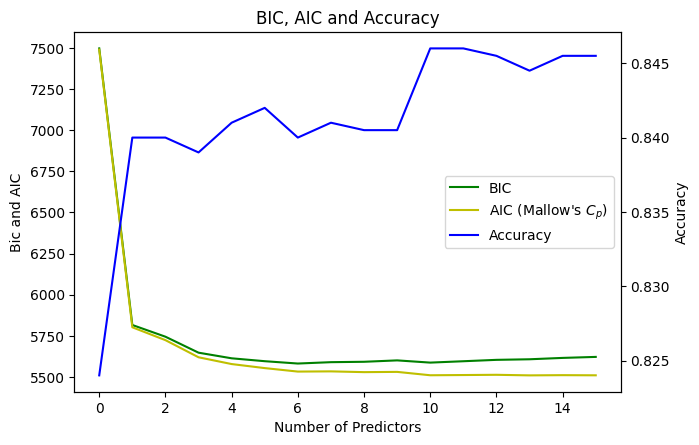

In [61]:
fig, ax1 = plt.subplots(figsize=(7, 5))

fig.tight_layout(pad=4.0)

ax2 = ax1.twinx()
BicPlot, = ax1.plot(bic, 'g-', label = "BIC")
AicPlot, = ax1.plot(aic, 'y-', label = "AIC (Mallow's $C_p$)")
AccuracyPlot, = ax2.plot(AccuracyTestData, 'b-', label="Accuracy")

plt.legend([BicPlot, AicPlot, AccuracyPlot], ['BIC', 'AIC (Mallow\'s $C_p$)', 'Accuracy'], loc = 'center right')

ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Bic and AIC')
ax2.set_ylabel('Accuracy')
plt.title("BIC, AIC and Accuracy")
plt.savefig(PathToRepo + '\\Plots\\BicAicAccuracy.png')

In [62]:
print(bic.idxmin()) #Finds where minimum  and maximum values are
print(aic.idxmin())
print(AccuracyTestData.idxmax())

6
13
10


In [63]:
model = models_best['model'].iloc[6]
summary = model.summary()
 
# Display and interpret results
with open(PathToRepo + '\\Tables\\GLMbestsubset.tex', 'w') as f:
    f.write(summary.as_latex())

#accuracy
pred = model.predict(sm.add_constant(x_test[model.params.index[1:]]))
print(accuracy_score(y_test, pred > 0.5))

summary

0.84


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          IsMigratorInt   No. Observations:                 7999
Model:                            GLM   Df Residuals:                     7992
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2759.4
Date:                Fri, 13 Dec 2024   Deviance:                       5518.8
Time:                        23:19:57   Pearson chi2:                 7.64e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2181
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4938      1.158     -1.290      0.197      -3.764       0.776
Rcyl           0.3973      0.017     22.913      0.000       0.363       0.431
vphi           0.0031      0.000      8.748      0.000       0.002       0.004
age           -0.4263      0.056     -7.599      0.000      -0.536      -0.316
ch            -2.0312      0.296     -6.871      0.000      -2.611      -1.452
ofe          -15.1186      3.155     -4.792      0.000     -21.302      -8.935
mgfe          28.7878      3.397      8.475      0.000      22.131      35.445
==============================================================================
"""